# Done by:
1. عبدالله محمد عبد الله محمد طمان (20010906)
2. محمود علي أحند علي غلاب (20011811)
3. كريم فتحي عبد العزيز (20011116)

Links helped us in this part:  
1 https://netpbm.sourceforge.net/doc/pgm.html  
Explains what is a pgm file.  
2 https://stackoverflow.com/questions/35723865/read-a-pgm-file-in-python  
Explains what is the pgm file.  
3 Now I'm facing a new issue which is the b character at the beginning of every line  
https://www.geeksforgeeks.org/effect-of-b-character-in-front-of-a-string-literal-in-python/  
4 Writing the data in a file for debugging  
https://www.pythonmorsels.com/creating-and-writing-file-python/#:~:text=To%20write%20to%20a%20text,file%20to%20write%20to%20it.

#Data Preparation

In [ ]:
def read_pgm(pgmf):
    """Return a raster of integers from a PGM as a list of lists."""
    assert pgmf.readline().decode('ascii') == 'P5\n'
    (width, height) = [int(i) for i in pgmf.readline().decode('ascii').split()]
    depth = int(pgmf.readline())
    assert depth <= 255

    raster = []
    for y in range(height):
        d = [];
        for y in range(width):
            d.append(ord(pgmf.read(1)))
        raster.append(d)
    return raster
data = []
label = []
for i in range(1,41):
    for j in range(1,11):
        f = open(f'/content/drive/MyDrive/faces/s{i}/{j}.pgm', 'rb')
        image = read_pgm(f)
        label.append(i)
        data.append(image)
num_images = len(data)
image_width = len(data[0])
image_height = len(data[0][0])

print(f"Number of images: {num_images}")
print(f"Width of images: {image_width}")
print(f"Height of images: {image_height}")

Number of images: 400
Width of images: 112
Height of images: 92


#Testing read_pgm function by showing first sample.

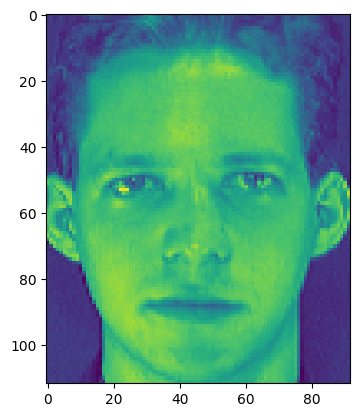

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
first_image = np.array(data[0])
plt.imshow(first_image.reshape(112,92))
plt.show()

#Importing Utility Packages

###Links that helped in this part: https://www.geeksforgeeks.org/k-nearest-neighbor-algorithm-in-python/

In [ ]:
import pandas as pd
from scipy import linalg
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import KNeighborsClassifier

#Data Preprocessing

###Now we'll try to reduce the number of pixels by the method mentioned here: https://stackoverflow.com/questions/48435977/reduce-number-of-pixels-to-obtain-low-resolution-image

###This function used to reduce pixels of the original image without extreme degradation on its quality by taking average of small group of pixels.

In [ ]:
def reduce_pixels(original_image, r):
    new_image = []
    l = 0
    for i in range(0, len(original_image), r):
        new_image.append([])
        for j in range(0, len(original_image[0]), r):
            s = 0
            for x in range(i, min(i + r, len(original_image))):
                for y in range(j, min(j + r, len(original_image[0]))):
                    s += original_image[x][y];
            new_image[l].append(s/(r*r))
        l = l + 1
    return new_image
def red(data, r):
    reduced_pixels_data = []
    for i in range(400):
        reduced_pixels_data.append(reduce_pixels(data[i], r))
    return reduced_pixels_data


#Data Vectorization
###flatten images to 10304 features i.e vector with [10304,1]

In [ ]:
def vectorize(reduced_pixels_data):
    reduced_pixels_data_vectorized = []
    for i in range(400):
        v = []
        for j in range(len(reduced_pixels_data[0])):
            for l in range(len(reduced_pixels_data[0][0])):
                v.append(reduced_pixels_data[i][j][l])
        reduced_pixels_data_vectorized.append(v)
    return reduced_pixels_data_vectorized

###splits (the train data and its labels) from (testing data and its labels.) and each class data separatec from its labels, too

In [ ]:
def splitter(v, label, s):
    train_data, test_data, train_labels, test_labels, = [], [], [], []
    if s == 0:
        train_data = np.array(v[1::2][:])
        test_data = np.array(v[0::2][:])
        train_labels = np.array(label[1::2].copy())
        test_labels = np.array(label[0::2].copy())
    else:
        for i in range(len(label)):
            if i % 10 < 7:
                train_data.append(v[i]), train_labels.append(label[i])
            else:
                test_data.append(v[i]), test_labels.append(label[i])
    return (train_data, test_data, train_labels, test_labels)

#PCA Algorithm

### note: Dataframe constructor has a strange behaviour

In [ ]:
def PCA(D, alpha):
    meu = np.mean(D, axis=0)
    z = D - meu
    z = np.around(z, decimals=2)
    E = z.T @ z
    eigenvalues, eigenvectors = np.linalg.eigh(E)
    total_variance = sum(eigenvalues)
    eigen_pairs = [(eigenvalues[i], eigenvectors[:, i]) for i in range(len(eigenvalues))]
    sorted_eigen_pairs = sorted(eigen_pairs, key=lambda x: x[0], reverse=True)
    Ut = []
    s = 0
    for eigenvalue, eigenvector in sorted_eigen_pairs:
        s += eigenvalue
        Ut.append(eigenvector)
        if(s/total_variance >= alpha):
            break;
    Ut = np.array(Ut)
    print(len(Ut))
    print(len(Ut[0]))
    P = Ut
    # P = Ut.T @ Ut
    return P

###handling performing pca algorithm on data.

In [ ]:
def PCA_handler(data, r, alpha, k, split):
    D = red(data, r)
    v = vectorize(D)
    (train_data, test_data, train_labels, test_labels) = splitter(v, label, split)
    train_data = np.array(train_data)
    test_data = np.array(test_data)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    P = PCA(train_data, alpha)
    projected_train_data = (P @ train_data.T).T
    projected_test_data = (P @ test_data.T).T
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(projected_train_data, train_labels)
    predict = (knn.predict(projected_test_data))
    acc = 0
    for i in range(len(test_labels)):
        if(test_labels[i] == predict[i]):
            acc += 1
    return (acc / len(test_labels) * 100)

##Showing first 5 shots of eigenvectors returned from pca

62
2576


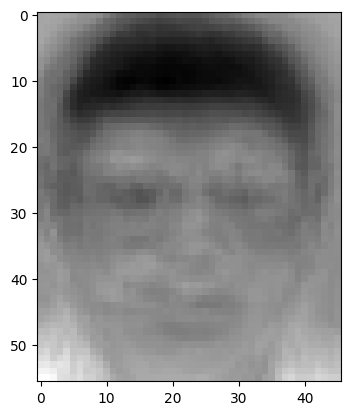

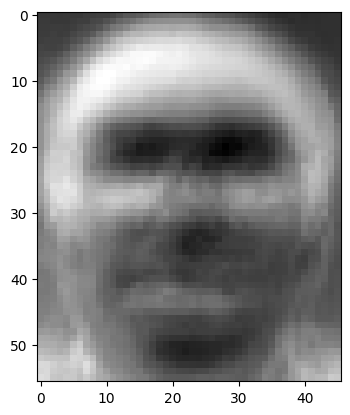

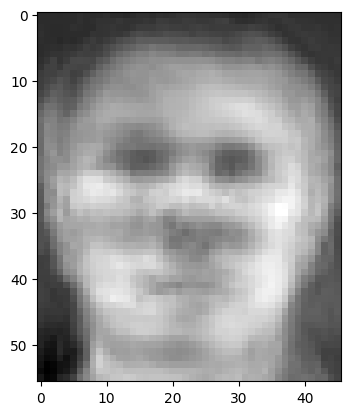

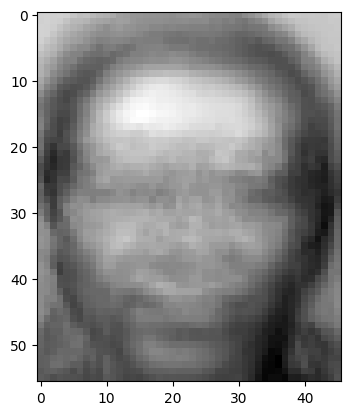

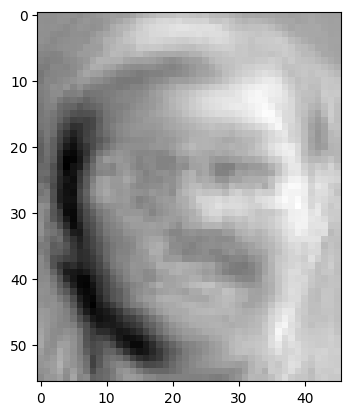

In [ ]:
D = red(data, 2)
v = vectorize(D)
training_set = splitter(v, label, 0)[0]
new_space = PCA(training_set, 0.9)
for i in range(5):
    plt.imshow(new_space[i].reshape(112//2, 92//2), cmap='gray')
    plt.show()

In [ ]:
def LDA_5_5(training_set):
    n_features = len(training_set[0])  # number of dimensions
    classes = 40  # no of components
    nk = 5  # no of samples for each class

    overall_mean = np.mean(training_set, axis=0).reshape(-1,
                                                         1)  # calculate mean of the dataset and convert it to be column vector

    # Computing the between-class scatter and within-scatter matrices
    Sb = np.zeros((n_features, n_features))
    S = np.zeros((n_features, n_features))
    for i in range(1, classes + 1):
        class_mean = (np.mean(training_set[(i - 1) * 5:(i * 5)], axis=0))  # mean verctor for class i
        column_class_mean_vec = class_mean.reshape(-1, 1)  # transforming to a column vector

        Sb += nk * np.dot((column_class_mean_vec - overall_mean),
                          (column_class_mean_vec - overall_mean).T)  # calculate scatter between matrix
        center_class = training_set[(i - 1) * 5:i * 5] - np.mean(training_set[(i - 1) * 5:i * 5],
                                                                 axis=0)  # calculate zi

        S += np.dot(center_class.T, center_class)  # scatter within matrix

    eigenvalues, eigenvectors = np.linalg.eig(np.dot(linalg.pinv(S), Sb))

    positions = eigenvalues.argsort()[::-1]
    # sorted_eigenvalues = (eigenvalues[positions])
    sorted_eigenvectors = (np.real(eigenvectors)[:, positions])
    # Taking only the dominant eigenvectors
    new_space = sorted_eigenvectors[:, :classes - 1]
    return new_space

##Bonus

In [ ]:
def LDA_7_3(training_set):
    n_features = len(training_set[0])
    classes = 40
    nk = 7
    overall_mean = np.mean(training_set, axis=0).reshape(-1, 1)  # column vector
    # Computing the between-class scatter matrix
    Sb = np.zeros((n_features, n_features))
    S = np.zeros((n_features, n_features))
    for i in range(1, classes + 1):
        class_mean = np.mean(training_set[(i - 1) * 7:i * 7], axis=0)
        class_mean = class_mean.reshape(-1, 1)  # mu(i)
        Sb += nk * np.dot((class_mean - overall_mean), (class_mean - overall_mean).T)  # scatter between class matrix
        centered_data = training_set[(i - 1) * 7:i * 7] - np.mean(training_set[(i - 1) * 7:i * 7], axis=0)
        S += np.dot(centered_data.T, centered_data)  # scatter within class matrix
    # Computing the eigenvalues and eigenvectors of the generalized eigenvalue problem
    eigenvalues, eigenvectors = np.linalg.eig(np.dot(linalg.pinv(S), Sb))

    positions = eigenvalues.argsort()[::-1]  # indices of eigenvectors which are sorted descendingly according to lamdas
    sorted_eigenvalues = (eigenvalues[positions])
    sorted_eigenvectors = (np.real(eigenvectors)[:, positions])
    # Taking only the dominant eigenvectors
    new_space = sorted_eigenvectors[:, :classes - 1]  # new vector space used for data projection to this new space
    return new_space

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis(solver='eigen', shrinkage='auto')

##LDA_handler is a function that allows us to perform LDA algorithms easily by preprocessing the data set(reduce_pixels, convert images to vectors and splits data into 4 subsets (training_data, training_labels, testing_data, testing_labels) and returns accuracy of lda algorithm performed.
###it takes 4 params:
###p1: data -> data set
###p2: r -> reduction ratio
###p3: k -> k-nearest neighbors
###p4: split -> split -> splits the data set into two subsets (training and testing) <b>0<b/> for 50% training and 50% testing and <b>1<b/> for 70% training and 30% testing

In [ ]:
def LDA_handler(data, r, k, split):
    D = red(data, r)
    v = vectorize(D)
    (train_data, test_data, train_labels, test_labels) = splitter(v, label, split)
    train_data = np.array(train_data)
    test_data = np.array(test_data)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    Ut = LDA_5_5(train_data)
    projected_train_data = np.dot(train_data, Ut)  #(Ut.T @ train_data.T).T
    projected_test_data = np.dot(test_data, Ut)  #(Ut.T @ test_data.T).T
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(projected_train_data, train_labels)
    # predict = (knn.predict(projected_test_data))
    return knn.score(projected_test_data, test_labels)
    # acc = 0
    # for i in range(len(test_labels)):
    #     if (test_labels[i] == predict[i]):
    #         acc += 1
    # return (acc / len(test_labels) * 100)

##Bonus (PCA variation algorithm) called Kernel_PCA.

###<ul><li>compute_k function is just computing the kernel matrix which is used by kernel pca algorithm</li> <li>Kernel PCA algorithm</li> </ul>


In [ ]:
def compute_K(D, kernel_function):
    K = []
    n = len(D)
    I = np.identity(n)
    ONE = np.ones((n, n))
    for i in range(n): # samples^2
        ki = []
        for j in range(n):
            ki.append(kernel_function([D[i]], [D[j]])[0][0])
        K.append(ki)
    K = np.array(K)
    K = (I - (1/n)*ONE)@K@(I - (1/n)*ONE) #samples^3
    return K
def KernelPCA(D, alpha, K):
    n = len(D)
    eigenvalues, eigenvectors = np.linalg.eigh(K) # dimensions^3
    for i in range(len(eigenvalues)):
        if(eigenvalues[i] <= 0):
            eigenvalues[i] = 0 # error in decimal
    eigen_pairs = [(eigenvalues[i], eigenvectors[:, i]) for i in range(len(eigenvalues))]
    sorted_eigen_pairs = sorted(eigen_pairs, key=lambda x: x[0], reverse=True)
    CrT = []
    s = 0
    total_variance  = sum(eigenvalues)/n
    for eigenvalue, eigenvector in sorted_eigen_pairs:
        if(eigenvalue == 0):
            break
        s += eigenvalue/n
        CrT.append(eigenvector/(np.sqrt(eigenvalue)))
        if(s/total_variance >= alpha):
            break;
    CrT = np.array(CrT)
    return CrT

In [ ]:
def kernel_PCA_handler(data, r, alpha, k, split):
    D = red(data, r)
    v = vectorize(D)
    (train_data, test_data, train_labels, test_labels) = splitter(v, label, split)
    train_data = np.array(train_data)
    test_data = np.array(test_data)
    train_labels = np.array(train_labels)
    test_labels = np.array(test_labels)
    K1 = compute_K(train_data, cosine_similarity)
    CrT = KernelPCA(train_data, alpha, K1)
    K2 = compute_K(test_data, cosine_similarity)
    projected_train_data = (CrT @ K1.T).T
    projected_test_data = (CrT @ K2.T).T
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(projected_train_data, train_labels)
    predict = (knn.predict(projected_test_data))
    acc = 0
    for i in range(len(test_labels)):
        if(test_labels[i] == predict[i]):
            acc += 1
    return (acc / len(test_labels) * 100)

##perform pca is function that applies pca algorithms on data.
###p1: what_type -> (traditional, kernel)?
###p2: data -> data set
###p3: r -> reduction ratio
###p4: alpha -> accuracy probability
###p5: k -> k-nearest neighbors for the sample
###p6: split -> splits the data set into two subsets (training and testing) <b>0<b/> for 50% training and 50% testing and <b>1<b/> for 70% training and 30% testing

In [ ]:
def perform_PCA(what_type, data, r, alpha, k, split):
    if(what_type == 0):
        return kernel_PCA_handler(data, r, alpha, k, 0)
    else:
        return PCA_handler(data, r, alpha, k, split)

##perform lda is a function that applies lda algorithm on data.
###p1: what_type -> (traditional, kernel)?
###p2: data -> data set
###p3: r -> reduction ratio
###p4: k -> k-nearest neighbors for the sample
###p5: split -> splits the data set into two subsets (training and testing) <b>0<b/> for 50% training and 50% testing and <b>1<b/> for 70% training and 30% testing

In [ ]:
def perform_LDA(what_type, data, r, k, split):
    return LDA_handler(data, r, k, 0)

#Algorithms Analysis and comparison between pca and lda accuracies.

In [ ]:
def compare():
    for r in range(2, 16, 2):
        for alpha in np.arange(.8, 1, 0.05):
            for k in range(1, 8, 2):
                for split in range(0,2,1):
                    pca_acc = perform_PCA(1, data, r, alpha, k, split)
                    lda_acc = perform_LDA(1, data, r, k, split)
                    print("r: " + str(r) + " alpha: " + str(alpha) + " k: " + str(k) + " split: " + str(
                        split) + " PCA acc: " + str(pca_acc) + " " + " " + "LDA acc: " + str(
                        lda_acc) + "\n")
compare()

29
2576
r: 2 alpha: 0.8 k: 1 split: 0 PCA acc: 93.0  LDA acc: 0.96

30
2576
r: 2 alpha: 0.8 k: 1 split: 1 PCA acc: 95.83333333333334  LDA acc: 0.96

29
2576
r: 2 alpha: 0.8 k: 3 split: 0 PCA acc: 84.5  LDA acc: 0.92

30
2576
r: 2 alpha: 0.8 k: 3 split: 1 PCA acc: 94.16666666666667  LDA acc: 0.92

29
2576
r: 2 alpha: 0.8 k: 5 split: 0 PCA acc: 81.5  LDA acc: 0.935

30
2576
r: 2 alpha: 0.8 k: 5 split: 1 PCA acc: 90.0  LDA acc: 0.935

29
2576
r: 2 alpha: 0.8 k: 7 split: 0 PCA acc: 77.5  LDA acc: 0.935

30
2576
r: 2 alpha: 0.8 k: 7 split: 1 PCA acc: 83.33333333333334  LDA acc: 0.935

41
2576
r: 2 alpha: 0.8500000000000001 k: 1 split: 0 PCA acc: 94.0  LDA acc: 0.96

44
2576
r: 2 alpha: 0.8500000000000001 k: 1 split: 1 PCA acc: 95.83333333333334  LDA acc: 0.96

41
2576
r: 2 alpha: 0.8500000000000001 k: 3 split: 0 PCA acc: 86.0  LDA acc: 0.92

44
2576
r: 2 alpha: 0.8500000000000001 k: 3 split: 1 PCA acc: 94.16666666666667  LDA acc: 0.92

41
2576
r: 2 alpha: 0.8500000000000001 k: 5 split: 0 PC

Links that helped us in this part:  
1 How to split the matrix  
https://www.mathworks.com/matlabcentral/answers/102465-how-do-i-extract-the-odd-and-even-rows-of-my-matrix-into-two-separate-matrices-and-reconstruct-it-ba  
https://www.geeksforgeeks.org/python-list-slicing/  
2 A dataframe or a python list  
https://www.quora.com/What-is-the-difference-between-a-DataFrame-and-a-list-of-tuples-in-Python-Which-is-better-in-terms-of-performance#:~:text=DataFrames%20also%20have%20built%2Din,datasets%20with%20a%20simple%20structure.

### Some analysis based on the numbers we received in the last part
We got the graphs after writing the results into a file and used r ggplot2 library to draw the plots and here is the r codes we used:  
pca_numbers = read.csv("J:/champions work/datasets/Trials.csv")  
ggplot(data = pca_numbers, mapping = aes(x = alpha , y = accuracy)) + geom_point( mapping = aes(color = k)) + geom_smooth(method = "lm")  
ggplot(data = pca_numbers, mapping = aes(x = r, y = accuracy)) + geom_point(mapping = aes( color = alpha)) + geom_smooth(method = "lm")  
ggplot(split, aes(x = split, y = accuracy, fill = split)) +
  geom_violin() +
  geom_boxplot(width = 0.1, fill = "white", color = "black") +
  labs(title = "Comparison of Accuracy between 50:50 and 70:30 Splits",
       x = "Split",
       y = "Accuracy") +
  theme_minimal()
ggsave("J:/comparison_plot.png", width = 6, height = 4, units = "in", dpi = 300)
kernel_vs_normal <- read.table("J:\\champions work\\datasets\\e.txt", header = TRUE)
kernel = kernel_vs_normal[c(1:4)]
normal = kernel_vs_normal[c(1:3, 5)]
kernel$type = "Kernel"
normal$type = "Normal"
glimpse(kernel)
glimpse(normal)
kernel = kernel %>%
  rename(
     accuracy = kernel_PCA_accuracy
  )
normal = normal %>%
  rename(
     accuracy = normal_PCA_accuracy
  )
kernel_vs_normal <- rbind(kernel, normal)
glimpse(kernel_vs_normal)
ggplot(kernel_vs_normal, aes(x = accuracy, color = type)) + geom_density(linewidth = .75)
ggsave("J:/final.png", width = 6, height = 4, units = "in", dpi = 300)
ggplot(kernel_vs_normal, aes(x = kernel_vs_normal, y = accuracy, color = type)) + geom_point()


![picture](https://drive.google.com/uc?export=view&id=11V2SoIfaQy-KipYhtI5mXXnMbI3DoQxU)

### Relationship Between Independent Variables alpha and k and The Dependent Variable Accuracy
As we can see, the more we increased alpha the more the accuracy of the classifier increaese, which mean that the pca has kept more of the data aesthetics in the new dimension.  
When we look at the legend at the right of the data we'll see that the lighter blue, the higher the k is, k is the variable used in the Knn. We use the default tie break method in the algorithm. We can see that the more we increae the k, the less the accuracy is for the same alpha.


![picture](https://drive.google.com/uc?export=view&id=1eZiH-PWrQdj0WhzWvMtukpaGUPV6Kj0N)

### Relationshipe Between r and Accuracy  
What is r ? It's the side lenght of the square of pixels which we replace by the average of its pixels.  
The plot shows us that the decay in the linear model fitting the points has a small negative slop, which shows that decreasing the number of pixels didn't affect the quality of the result that hard, and we can decrease the pixels without fearing a bad decay in performance.

### Comparison Between Different Splits   

![picture](https://drive.google.com/uc?export=view&id=1sIArCXoeTWUGpueh9ITMZRj8_YgQKmA5)

As we can see, on average the 70:30 split is achieving higher accuracy than the 50:50 split and this is logical, as we have more points to compare with now.

![picture](https://drive.google.com/uc?export=view&id=1hSYCMbvgxcTAsvINoTpxGAnaLr7d7Niq)

Comparing between the kernel PCA and the normal PCA
We can see that normal PCA is achieving higher accuracy than the kernel one more times, and the kernel is more stable than the normal one and follows a normal distribution, it achieves a good accuracy on average.


# **the time complexity of normal PCA is O(dimensions^3) while the time complexity of kernel PCA is O(n^3) while LDA complexity is O(min(n,d)^3)**

Link to the data that derived these charts:
https://drive.google.com/drive/folders/1JpjuHgiJjHimvyEu7SO9IYhxFWj3PvtX?usp=sharing

**Some Analysis On the LDA Part**
1. Variations Of r and its Relationship with Accuracy
The more we increase r the less the accuracy becomes, and this is logical. But r is getting
2. Variations of k and its Relationshipe with Accuracy

3. Variations of splits and its Relationship with Accuracy


# Some Analysis On the LDA Part
1. Variations Of r and its Relationship with Accuracy
The more we increase r the less the accuracy becomes, and this is logical. Because the number of features is decreasing when we increase r.
![picture](https://drive.google.com/uc?export=view&id=11gIFeACB_WOadV0NYaiB-1fZZlbap7W3)
2. Variations of k and its Relationshipe with Accuracy
The more we increase k, the less on average the accuracy becomes, just like the PCA.
![picture](https://drive.google.com/uc?export=view&id=1qxBoVbdvud7-UUXYhC2_3IrtoIgtIvGy)
3. Variations of splits and its Relationship with Accuracy
The 70-30 split is better than the 50-50 split. And this is logical of course, the accuracy of the projections will increae as we're getting a higher variation of data as input.
![picture](https://drive.google.com/uc?export=view&id=1OTxjBtliv4HImSnuLDh7379DoGAykMrz)

**Comparison Between PCA and LDA**
When we averaged the results of PCA at different alphas, at 50-50 splits in both, we found out that LDA was better
![picture](https://drive.google.com/uc?export=view&id=1Ep6honPDw30-byHsGVzXIemPwfhuiIOv)

* LDA has higher accuracies than PCA



# Classifier Tuning

1. **Set the number of neighbors in the K-NN classifier to 1,3,5,7**
The comparisons for different neighbors count are already shown in the previous graphs


## Tie breaking at your preferred strategy.

The tie-breaking policy in the KNeighborsClassifier class in scikit-learn primarily uses the brute-force algorithm when the number of samples (n_samples) is relatively small. In the brute-force algorithm, tie-breaking is handled by the order of appearance of neighbors in the training data.

## Plot (or tabulate) the performance measure (accuracy) against the K value. This is to be done for PCA and LDA as well.

plot for LDA


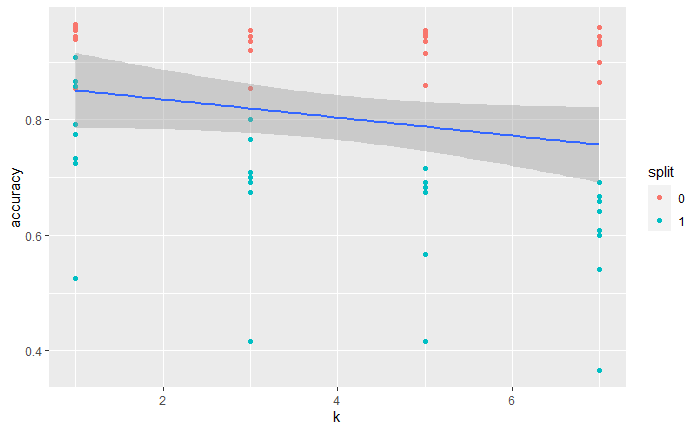


plots for PCA are stated previously

# Faces vs Non-Faces part


## importing datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/faces /home

In [ ]:
!cp -r /content/drive/MyDrive/nonFaces /home

In [ ]:
!cp -r /content/drive/MyDrive/modified /home

In [ ]:
faces_dataset_dir = "/home/faces"
nonfaces_train_data_dir = "/home/nonFaces/dataset/cars_vs_flowers/training_set/All"
nonfaces_test_data_dir = "/home/nonFaces/dataset/cars_vs_flowers/test_set/All"

In [ ]:
import skimage as ski
import os
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
def loadFaces(data_dir,downscale_ratio):
    img_list = []
    for folder in os.listdir(data_dir):
        subdir = os.path.join(data_dir,folder)
        for file in os.listdir(subdir):
            img = ski.io.imread(os.path.join(subdir,file))
            img = ski.transform.downscale_local_mean(img,(downscale_ratio,downscale_ratio))
            img = img.flatten()
            img_list.append(img)
    return img_list

In [ ]:
def loadNonFacesData(data_dir,downscale_ratio):
    img_list = []
    for file in os.listdir(data_dir):
        filename = os.path.join(data_dir,file)
        img = ski.io.imread(filename)
        if(len(img.shape)>2):
            if(img.shape[2]==3):
                img = ski.color.rgb2gray(img)
            else:
                continue
        img = ski.transform.resize(img,(112,92))
        img = ski.transform.downscale_local_mean(img,(downscale_ratio,downscale_ratio))
        img = img.flatten()
        img_list.append(img)
    return img_list

In [ ]:
def data_splitter(faces_list,nonfaces_train_list,nonfaces_amount):
    training_set,test_set,training_labels,test_labels = [],[],[],[]
    training_set += faces_list[:300]
    training_set += nonfaces_train_list[:nonfaces_amount]


    training_labels += [1]*300
    training_labels += [2]*nonfaces_amount


    test_set += faces_list[300:]
    test_set += nonfaces_train_list[1898:]

    test_labels += [1]*100
    test_labels += [2]*100
    return [training_set,test_set,training_labels,test_labels]

We will calculate the accuracy of the guesses conducted using LDA by the **first** nearest neighbor classifier
i.e.:_k=1_

In [ ]:
def getAccuracy(projected_training_data,training_labels,projected_test_data,test_labels):
    incorrect_guess = []

    knn = KNeighborsClassifier(n_neighbors=1)
    knn.fit(projected_training_data,training_labels)
    predictions = knn.predict(projected_test_data)

    for i,prediction,true_label in zip(range(len(test_labels)),predictions,test_labels):
        if(prediction != true_label):
            incorrect_guess.append((i,prediction,true_label))
    accuracy = accuracy_score(test_labels,predictions)
    return [accuracy,incorrect_guess]

In [ ]:
import numpy as np

In [ ]:
def LDA_faces_vs_nonfaces(training_set,faces_amount,nonface_amount):

    # Computing the between-class scatter matrix
    faces_class = training_set[:faces_amount,:]
    nonfaces_class = training_set[faces_amount:,:]

    mean_face = np.mean(faces_class,axis=0)
    mean_nonface = np.mean(nonfaces_class,axis=0)
    data_mean = np.mean(training_set,axis=0)
    # Sb += nk * np.dot((column_class_mean_vec - overall_mean), (column_class_mean_vec - overall_mean).T)
    S1 = len(faces_class) * np.dot((mean_face-data_mean)[:,np.newaxis] ,(mean_face - data_mean)[:,np.newaxis].T)
    S2 = len(nonfaces_class) * np.dot((mean_nonface-data_mean)[:,np.newaxis] , (mean_nonface - data_mean)[:,np.newaxis].T)
    Sb = S1+S2


    Z1 = faces_class - mean_face
    Z2 = nonfaces_class - mean_nonface

    S = np.dot(Z1.T , Z1) +  np.dot(Z2.T , Z2)
    eigenvalues, eigenvectors = np.linalg.eig(np.linalg.pinv(S).dot(Sb)) #eigh is for symmetric only
    positions = eigenvalues.argsort()[::-1]
    sorted_eigenvalues = (eigenvalues[positions])
    sorted_eigenvectors = (eigenvectors[:, positions])
    # Taking only the dominant eigenvectors
    new_space = sorted_eigenvectors[:, :1]
    return new_space

## Getting the data needed for analysis

### PCA Analysis data



In [ ]:
analysis_data = {}
for r in range(2,5,1):
  faces_list = loadFaces(faces_dataset_dir,r)
  nonfaces_data_list = loadNonFacesData(nonfaces_train_data_dir,r)
  # nonfaces_test_list = loadNonFacesData(nonfaces_test_data_dir,r)
  for nonface_amount in range(50,301,50):
    training_set,test_set,training_labels,test_labels = data_splitter(faces_list,nonfaces_data_list,nonface_amount)
    train_data = np.vstack(training_set)
    test_data = np.vstack(test_set)
    for alpha in np.arange(0.8,1.0,0.05):
      projection_matrix = PCA(train_data,alpha)
      projected_train_data = (projection_matrix @ train_data.T).T
      projected_test_data = (projection_matrix @ test_data.T).T
      accuracy , incorrect_guesses = getAccuracy(projected_train_data,training_labels,projected_test_data,test_labels)
      analysis_data[(r,nonface_amount,alpha)] = accuracy

In [ ]:
analysis_data

{(2, 50, 0.8): 1.0,
 (2, 50, 0.8500000000000001): 1.0,
 (2, 50, 0.9000000000000001): 1.0,
 (2, 50, 0.9500000000000002): 1.0,
 (2, 100, 0.8): 1.0,
 (2, 100, 0.8500000000000001): 1.0,
 (2, 100, 0.9000000000000001): 1.0,
 (2, 100, 0.9500000000000002): 1.0,
 (2, 150, 0.8): 1.0,
 (2, 150, 0.8500000000000001): 1.0,
 (2, 150, 0.9000000000000001): 1.0,
 (2, 150, 0.9500000000000002): 1.0,
 (2, 200, 0.8): 1.0,
 (2, 200, 0.8500000000000001): 1.0,
 (2, 200, 0.9000000000000001): 1.0,
 (2, 200, 0.9500000000000002): 1.0,
 (2, 250, 0.8): 1.0,
 (2, 250, 0.8500000000000001): 1.0,
 (2, 250, 0.9000000000000001): 1.0,
 (2, 250, 0.9500000000000002): 1.0,
 (2, 300, 0.8): 1.0,
 (2, 300, 0.8500000000000001): 1.0,
 (2, 300, 0.9000000000000001): 1.0,
 (2, 300, 0.9500000000000002): 1.0,
 (3, 50, 0.8): 1.0,
 (3, 50, 0.8500000000000001): 1.0,
 (3, 50, 0.9000000000000001): 1.0,
 (3, 50, 0.9500000000000002): 1.0,
 (3, 100, 0.8): 1.0,
 (3, 100, 0.8500000000000001): 1.0,
 (3, 100, 0.9000000000000001): 1.0,
 (3, 100, 0.

**The accuracy of PCA is _100%_!!**

### the previous accuracy values founded by `pca` that are so high could be due to the nature of the nonfaces data samples

In [ ]:
faces_list = loadFaces(faces_dataset_dir,2)
nonfaces_data_list = loadNonFacesData(nonfaces_train_data_dir,2)
# nonfaces_test_list = loadNonFacesData(nonfaces_test_data_dir,2)
training_set,test_set,training_labels,test_labels = data_splitter(faces_list,nonfaces_data_list,200)
train_data = np.vstack(training_set)
test_data = np.vstack(test_set)
projection_matrix = PCA(train_data,0.99)
projected_train_data = (projection_matrix[0:1] @ train_data.T).T
projected_test_data = (projection_matrix[0:1] @ test_data.T).T
accuracy , incorrect_guesses = getAccuracy(projected_train_data,training_labels,projected_test_data,test_labels)

The next plot shows that the first 300 photos of the dataset(faces) represented on the y-axis are will scatterd while the next 200 photos (flowers & cars) are  projected to small area on the x axis they are projected on the first principle component

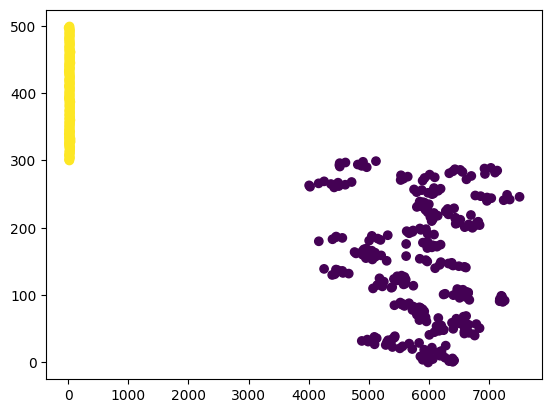

In [ ]:
import matplotlib.pyplot as plt
projected_train_data
plt.scatter(projected_train_data[:,0],range(len(projected_train_data)),c=training_labels)

### faces data have big variations

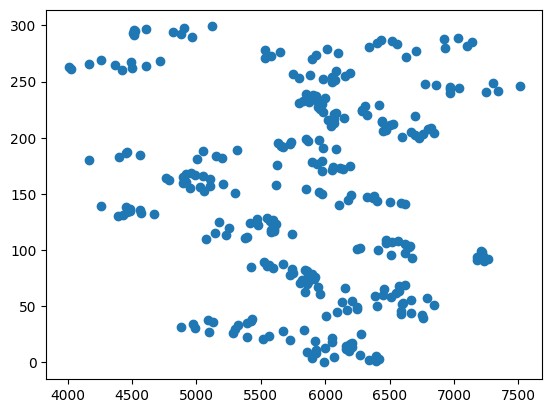

In [ ]:
projected_face_data = projected_train_data[:300]
plt.scatter(projected_face_data,range(len(projected_face_data)))

### Non faces data a have there own variations but compared to faces dataset their deviation is minimal

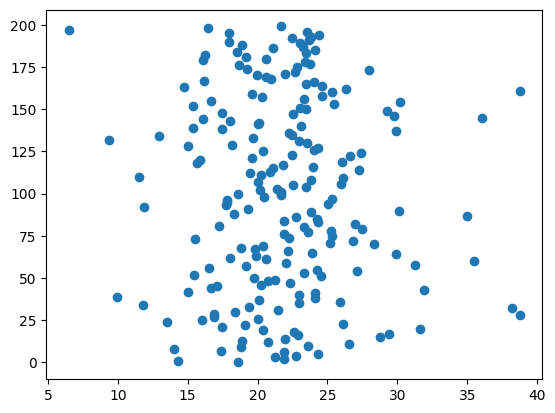

In [ ]:
projected_nonface_data = projected_train_data[300:]
plt.scatter(projected_nonface_data,range(len(projected_nonface_data)))

### LDA Analysis data

In [ ]:
lda_analysis_data = {}
incorrect_examples = {}
for r in range(2,5,1):
  faces_list = loadFaces(faces_dataset_dir,r)
  nonfaces_data_list = loadNonFacesData(nonfaces_train_data_dir,r)
  # nonfaces_test_list = loadNonFacesData(nonfaces_test_data_dir,r)
  for nonface_amount in range(100,1001,100):
    training_set,test_set,training_labels,test_labels = data_splitter(faces_list,nonfaces_data_list,nonface_amount)
    train_data = np.vstack(training_set)
    test_data = np.vstack(test_set)
    projection_matrix = LDA_faces_vs_nonfaces(train_data,300,nonface_amount)
    projected_train_data = (projection_matrix.T @ train_data.T).T
    projected_test_data = (projection_matrix.T @ test_data.T).T
    accuracy , incorrect_guesses = getAccuracy(projected_train_data.real,training_labels,projected_test_data.real,test_labels)
    incorrect_examples[(r,nonface_amount)] = incorrect_guesses
    lda_analysis_data[(r,nonface_amount)] = accuracy


In [ ]:
lda_analysis_data #large dataset

{(2, 100): 1.0,
 (2, 200): 0.99,
 (2, 300): 0.99,
 (2, 400): 0.99,
 (2, 500): 0.815,
 (2, 600): 0.98,
 (2, 700): 0.98,
 (2, 800): 0.985,
 (2, 900): 0.975,
 (2, 1000): 0.98,
 (3, 100): 1.0,
 (3, 200): 0.99,
 (3, 300): 0.985,
 (3, 400): 0.975,
 (3, 500): 0.98,
 (3, 600): 0.965,
 (3, 700): 0.955,
 (3, 800): 0.93,
 (3, 900): 0.82,
 (3, 1000): 0.915,
 (4, 100): 1.0,
 (4, 200): 0.99,
 (4, 300): 0.93,
 (4, 400): 0.955,
 (4, 500): 0.97,
 (4, 600): 0.985,
 (4, 700): 0.995,
 (4, 800): 0.99,
 (4, 900): 0.99,
 (4, 1000): 0.99}

In [ ]:
incorrect_examples

{(2, 100): [],
 (2, 200): [(45, 2, 1), (46, 2, 1)],
 (2, 300): [(45, 2, 1), (56, 2, 1)],
 (2, 400): [(45, 2, 1), (56, 2, 1)],
 (2, 500): [(2, 2, 1),
  (15, 2, 1),
  (18, 2, 1),
  (22, 2, 1),
  (24, 2, 1),
  (25, 2, 1),
  (26, 2, 1),
  (28, 2, 1),
  (29, 2, 1),
  (30, 2, 1),
  (31, 2, 1),
  (32, 2, 1),
  (37, 2, 1),
  (38, 2, 1),
  (41, 2, 1),
  (43, 2, 1),
  (48, 2, 1),
  (49, 2, 1),
  (51, 2, 1),
  (53, 2, 1),
  (54, 2, 1),
  (55, 2, 1),
  (56, 2, 1),
  (57, 2, 1),
  (59, 2, 1),
  (60, 2, 1),
  (65, 2, 1),
  (70, 2, 1),
  (72, 2, 1),
  (74, 2, 1),
  (78, 2, 1),
  (82, 2, 1),
  (84, 2, 1),
  (86, 2, 1),
  (87, 2, 1),
  (88, 2, 1),
  (89, 2, 1)],
 (2, 600): [(45, 2, 1), (46, 2, 1), (48, 2, 1), (56, 2, 1)],
 (2, 700): [(45, 2, 1), (46, 2, 1), (48, 2, 1), (56, 2, 1)],
 (2, 800): [(46, 2, 1), (47, 2, 1), (48, 2, 1)],
 (2, 900): [(41, 2, 1), (46, 2, 1), (47, 2, 1), (48, 2, 1), (56, 2, 1)],
 (2, 1000): [(46, 2, 1), (47, 2, 1), (48, 2, 1), (89, 2, 1)],
 (3, 100): [],
 (3, 200): [(45, 2, 1), (

#Some incorrect guesses
at downsampling of 4:1 ratio and using 300 faces and 100 non faces using `lda`


In [ ]:
faces_list = loadFaces(faces_dataset_dir,1)
nonfaces_data_list = loadNonFacesData(nonfaces_train_data_dir,1)
# nonfaces_test_list = loadNonFacesData(nonfaces_test_data_dir,1)
training_set,test_set,training_labels,test_labels = data_splitter(faces_list,nonfaces_data_list,200)


In [ ]:
import matplotlib.pyplot as plt

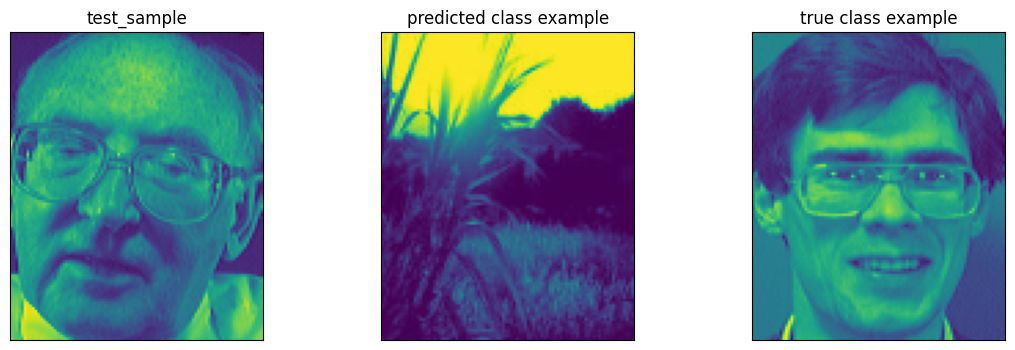

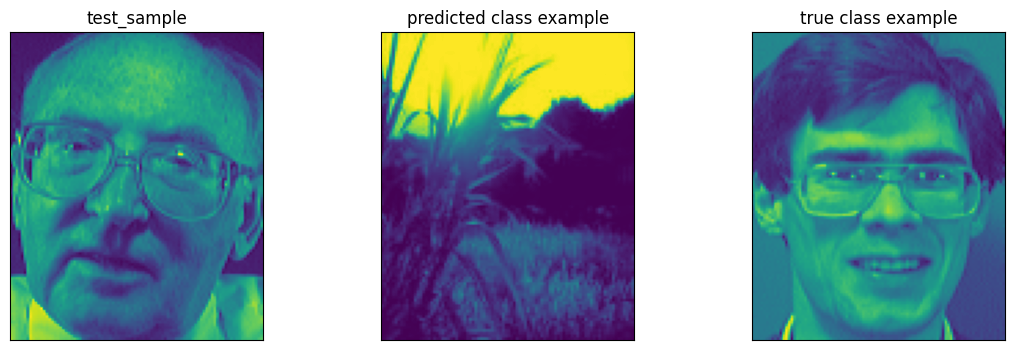

In [ ]:
for incorrect_sample,class_prediction,true_class in incorrect_examples[(2, 200)]:
    incorrect_sample_img = test_set[incorrect_sample]
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    img1 = incorrect_sample_img.reshape(112,92)
    img2 = test_set[(class_prediction*100)-50].reshape(112,92)
    img3 = test_set[(true_class*100)-50].reshape(112,92)

    # Plot each image on its corresponding subplot
    axes[0].imshow(img1)
    axes[1].imshow(img2)
    axes[2].imshow(img3)


    # Adjust spacing between subplots to avoid overlapping titles (optional)
    plt.subplots_adjust(left=0.05, right=0.95, wspace=0.1)  # Adjust values as needed

    # Display titles for each image (optional)
    axes[0].set_title('test_sample')
    axes[1].set_title('predicted class example')
    axes[2].set_title('true class example')

    # Remove unnecessary ticks and labels (optional)
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

## How many dominant eigenvectors will you use for the LDA solution?

**we will use _1 dominant eigen_ vector only as ther exists just 2 classes _(faces & non_faces)_ and in LDA we extract (number of classes-1) dominant eigenvectors**

# Plot the accuracy vs the number of non-faces images while fixing the number of face images.


we fixed the number of faces used in the analysis to be **300** used for training data and **100** used in validation
we used **100** photos of non faces in validation to make the total length of the validation set = **200**

* we won't make any analysis for pca due to the previously mentioned fact about the data set



### organizing data
* we will average the accureacies of the cases that had the same downscale ratio


In [ ]:
values = lda_analysis_data.values()
D = []
for val in values:
  D.append(val)
D = np.array(D)
D = D.reshape(3,10)
D = np.mean(D,axis=0)
D

array([1.        , 0.99      , 0.96833333, 0.97333333, 0.92166667,
       0.97666667, 0.97666667, 0.96833333, 0.92833333, 0.96166667])

### plotting

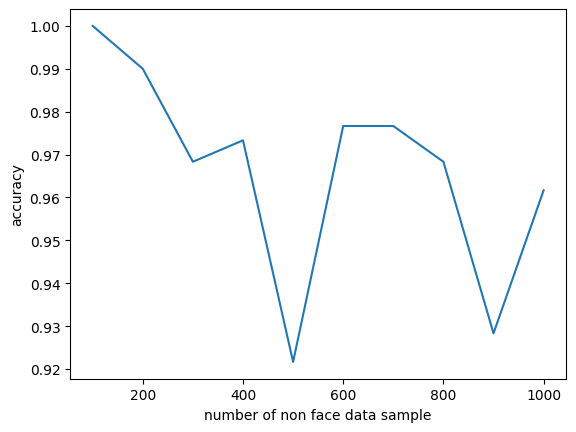

In [ ]:
plt.plot(range(100,1001,100),D)
plt.xlabel("number of non face data sample")
plt.ylabel("accuracy")
plt.show()

### Criticize the accuracy measure for large numbers of non-faces images in the training data.

as the size of one class becomes significantly larger than the other a bias for the majority class happens Bias towards the majority class:
**LDA identifies discriminative features by analyzing the scatter matrices of each class. A larger class will have a much higher variance, skewing the overall scatter and potentially overwhelming the contribution of the smaller class.**

# Using a different dataset with smaller number of non face samples with more varied sample

In [ ]:
!cp -r /content/drive/MyDrive/faces /home

In [ ]:
!cp -r /content/drive/MyDrive/modified /home

In [ ]:
faces_path = "/home/faces"
nonface_path = "/home/modified"

In [ ]:
import os
import skimage as ski

In [ ]:
def load_data(data_path,r):
  img_list = [];
  for folder in os.listdir(data_path):
    new_path = os.path.join(data_path,folder)
    for img_file in os.listdir(new_path):
      img = ski.io.imread(os.path.join(new_path,img_file))
      img = ski.transform.downscale_local_mean(img,(r,r))
      img = img.flatten()
      img_list.append(img)
  return img_list


In [ ]:
import numpy as np

In [ ]:
def PCA(data,alpha):
  data_mean = np.mean(data,axis= 0)
  z = data-data_mean

  covariance = np.cov(z.T)

  eignVal , eignVectors = np.linalg.eigh(covariance)

  sorted_indx = np.argsort(eignVal)[::-1]
  eignVal = eignVal[sorted_indx]
  eignVectors = eignVectors[:,sorted_indx]

  counter = 0
  total_variance = np.sum(eignVal)
  accu_sum = 0
  for eigvalue in eignVal:
    counter+=1
    accu_sum += eigvalue
    if((accu_sum/total_variance)>=alpha):
      break

  return eignVectors[:,:counter]

In [ ]:
def LDA(data,labels):
  data_classes = {}
  for img,label in zip(data,labels):
    if(label not in data_classes):
      data_classes[label]=[]
    data_classes[label].append(img)

  data_classes = list(data_classes.values())
  overall_mean = np.mean(data,axis=0)

  Sb = np.zeros((data.shape[1],data.shape[1]))
  S = np.zeros((data.shape[1],data.shape[1]))

  for K in data_classes:
    class_matrix = np.vstack(K)
    class_mean = np.mean(class_matrix,axis=0)
    Zk = class_matrix-class_mean
    Sb+= len(class_matrix) * (class_mean-overall_mean)[:,np.newaxis]@(class_mean-overall_mean)[:,np.newaxis].T
    S += Zk.T@Zk

  eigVals,eigVectors = np.linalg.eig(np.linalg.pinv(S)@Sb)

  soreted_indx = np.argsort(eigVals.real)[::-1]
  eigVectors = eigVectors[:,soreted_indx].real

  return eigVectors[:,:1]


In [ ]:
def data_splitter(face_imgs,nonface_imgs,nonface_amount):
  training_set,training_labels,test_set,test_labels = [],[],[],[]

  training_set += face_imgs[:300]
  training_set += nonface_imgs[:nonface_amount]

  training_labels += [1]*300
  training_labels += [2]*nonface_amount

  test_set += face_imgs[300:]
  test_set += nonface_imgs[300:]

  test_labels += [1]*100
  test_labels += [2]*100

  return training_set,training_labels,test_set,test_labels



In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [ ]:
def getAccuracy(training_set,training_labels,test_set,test_labels):
  incorrect_guesses =[]
  correct_guesses = []
  knn = KNeighborsClassifier(n_neighbors=1)
  knn.fit(training_set,training_labels)
  predictions = knn.predict(test_set)
  for i,prediction,true_label in zip(range(len(test_labels)),predictions,test_labels):
    if(prediction == true_label):
      correct_guesses.append((i,prediction,true_label))
    else:
      incorrect_guesses.append((i,prediction,true_label))

  return accuracy_score(test_labels,predictions)*100,incorrect_guesses,correct_guesses

In [ ]:
face_imgs = load_data(faces_path,2)
nonface_imgs = load_data(nonface_path,2)
pca_collected_data = {}
correct_examples = {}
incorrect_examples = {}
for nonface_amount in range(50,301,50):
  training_set,training_labels,test_set,test_labels = data_splitter(face_imgs,nonface_imgs,nonface_amount)
  training_set = np.vstack(training_set)
  test_set = np.vstack(test_set)
  for alpha in np.arange(0.8,1.0,0.05):
    projection_matrix = PCA(training_set,alpha)
    preojected_train_data = (projection_matrix.T@training_set.T).T
    preojected_test_data = (projection_matrix.T@test_set.T).T
    accu,incorrect_guesses,correct_guesses = getAccuracy(preojected_train_data,training_labels,preojected_test_data,test_labels)
    pca_collected_data[(nonface_amount,alpha)] = accu
    correct_examples[(nonface_amount,alpha)] = correct_guesses
    incorrect_examples[(nonface_amount,alpha)] = incorrect_guesses
pca_collected_data

{(50, 0.8): 84.0,
 (50, 0.8500000000000001): 84.0,
 (50, 0.9000000000000001): 82.5,
 (50, 0.9500000000000002): 80.0,
 (100, 0.8): 91.5,
 (100, 0.8500000000000001): 91.5,
 (100, 0.9000000000000001): 91.5,
 (100, 0.9500000000000002): 90.0,
 (150, 0.8): 94.5,
 (150, 0.8500000000000001): 92.0,
 (150, 0.9000000000000001): 92.0,
 (150, 0.9500000000000002): 91.5,
 (200, 0.8): 97.0,
 (200, 0.8500000000000001): 97.0,
 (200, 0.9000000000000001): 93.5,
 (200, 0.9500000000000002): 93.5,
 (250, 0.8): 95.5,
 (250, 0.8500000000000001): 95.0,
 (250, 0.9000000000000001): 93.5,
 (250, 0.9500000000000002): 93.5,
 (300, 0.8): 97.0,
 (300, 0.8500000000000001): 95.0,
 (300, 0.9000000000000001): 93.5,
 (300, 0.9500000000000002): 93.5}

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
face_imgs = load_data(faces_path,1)
nonface_imgs = load_data(nonface_path,1)
training_set,training_labels,test_set,test_labels = data_splitter(face_imgs,nonface_imgs,250)

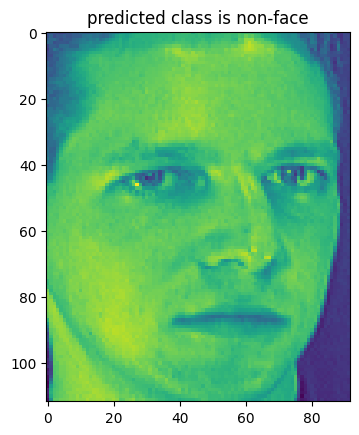

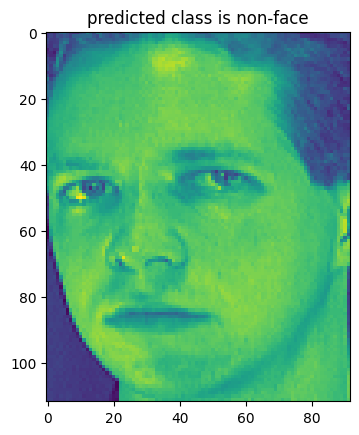

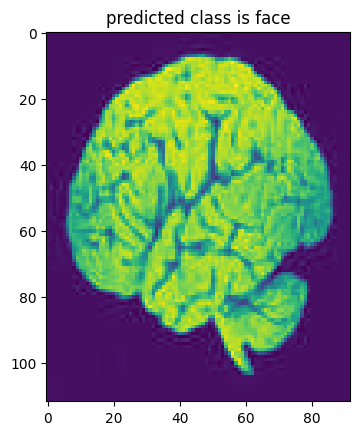

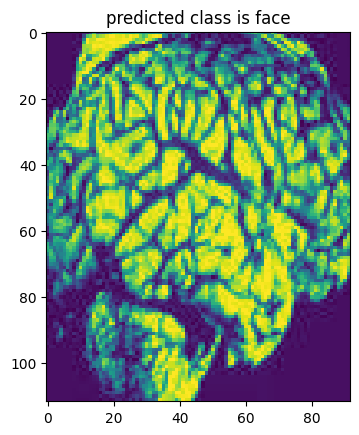

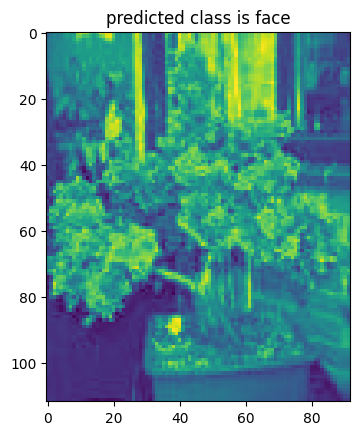

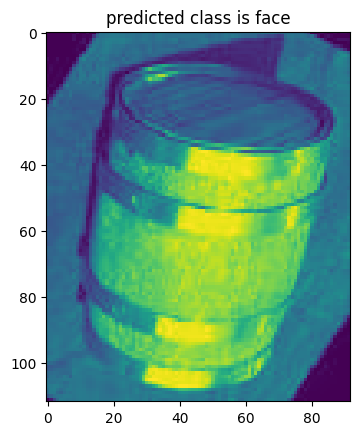

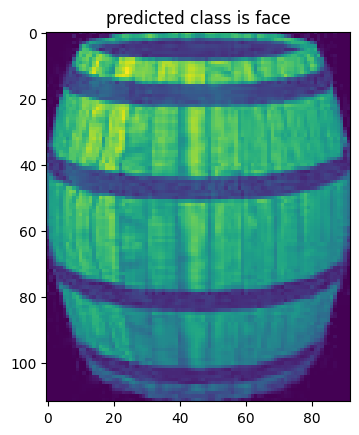

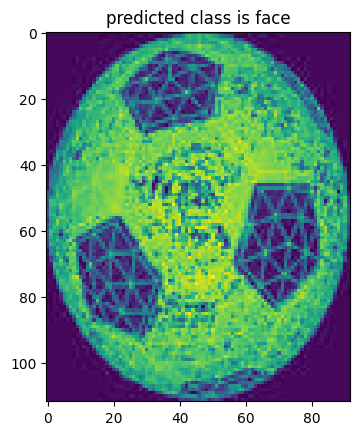

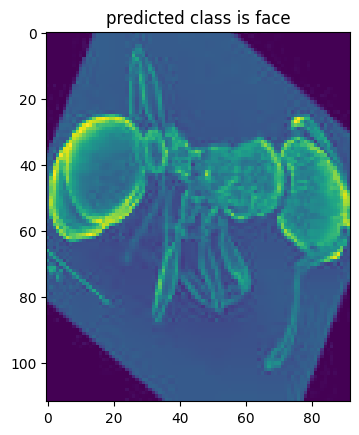

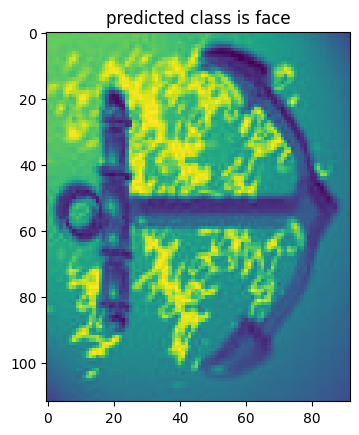

In [ ]:
for incorrect_example,class_prediction,true_class in incorrect_examples[(250, 0.8500000000000001)]:
  incorrect_sample_img = test_set[incorrect_example]
  img = incorrect_sample_img.reshape(112,92)
  plt.imshow(img)
  predictied_class = "face" if class_prediction==1 else "non-face"
  plt.title(f"predicted class is {predictied_class}")
  plt.show()

In [ ]:
values = pca_collected_data.values()
D = []
for val in values:
  D.append(val)
D = np.array(D)
D = D.reshape(6,4)
D

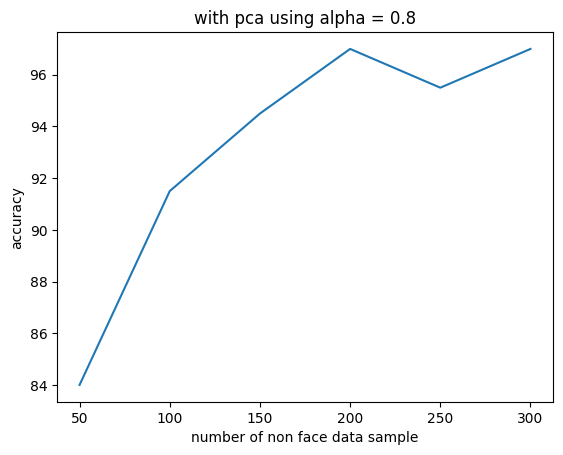

In [ ]:
plt.plot(range(50,301,50),D[:,0])
plt.xlabel("number of non face data sample")
plt.ylabel("accuracy")
plt.title("with pca using alpha = 0.8")
plt.show()

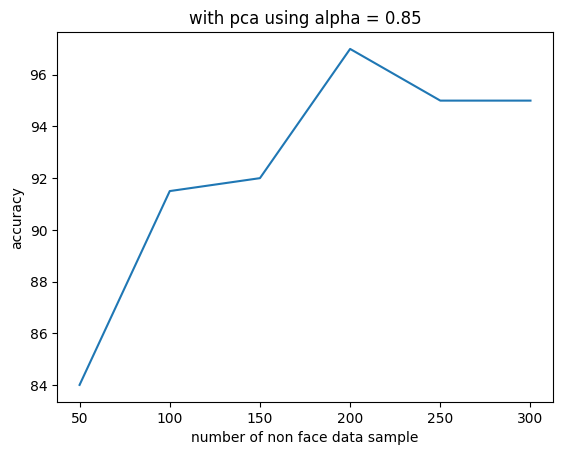

In [ ]:
plt.plot(range(50,301,50),D[:,1])
plt.xlabel("number of non face data sample")
plt.ylabel("accuracy")
plt.title("with pca using alpha = 0.85")
plt.show()

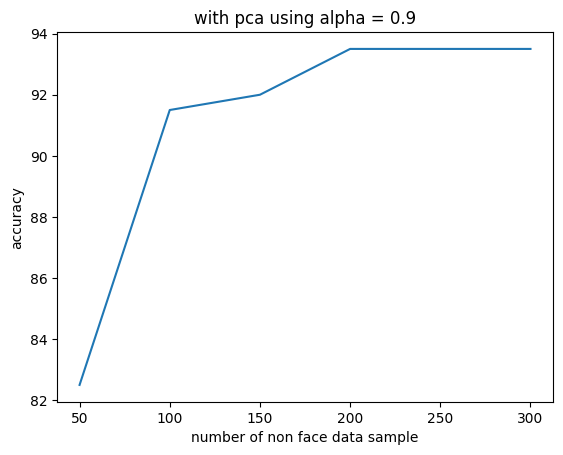

In [ ]:
plt.plot(range(50,301,50),D[:,2])
plt.xlabel("number of non face data sample")
plt.ylabel("accuracy")
plt.title("with pca using alpha = 0.9")
plt.show()

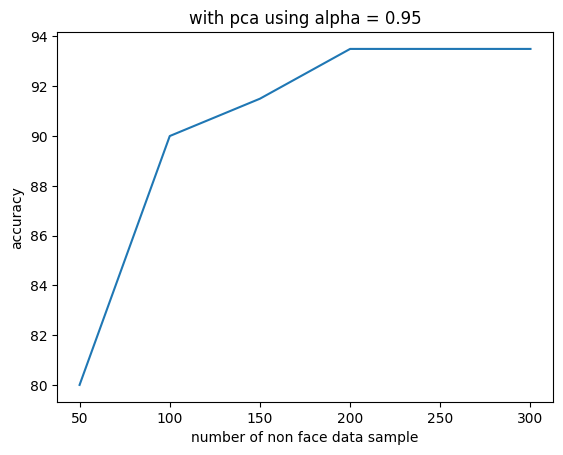

In [ ]:
plt.plot(range(50,301,50),D[:,3])
plt.xlabel("number of non face data sample")
plt.ylabel("accuracy")
plt.title("with pca using alpha = 0.95")
plt.show()

In [ ]:
face_imgs = load_data(faces_path,2)
nonface_imgs = load_data(nonface_path,2)
lda_collected_data = {}
ldacorrect_examples = {}
ldaincorrect_examples = {}
for nonface_amount in range(50,301,50):
  training_set,training_labels,test_set,test_labels = data_splitter(face_imgs,nonface_imgs,nonface_amount)
  training_set = np.vstack(training_set)
  test_set = np.vstack(test_set)
  projection_matrix = LDA(training_set,training_labels)
  preojected_train_data = (projection_matrix.T@training_set.T).T
  preojected_test_data = (projection_matrix.T@test_set.T).T
  accu,incorrect_guesses,correct_guesses = getAccuracy(preojected_train_data,training_labels,preojected_test_data,test_labels)
  lda_collected_data[(nonface_amount)] = accu
  ldacorrect_examples[(nonface_amount)] = correct_guesses
  ldaincorrect_examples[(nonface_amount)] = incorrect_guesses
lda_collected_data

{50: 50.0, 100: 44.0, 150: 79.0, 200: 82.0, 250: 82.0, 300: 84.5}

In [ ]:
face_imgs = load_data(faces_path,1)
nonface_imgs = load_data(nonface_path,1)
training_set,training_labels,test_set,test_labels = data_splitter(face_imgs,nonface_imgs,300)

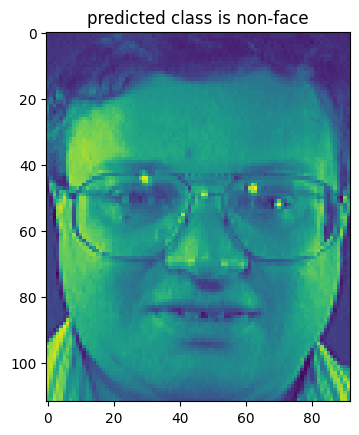

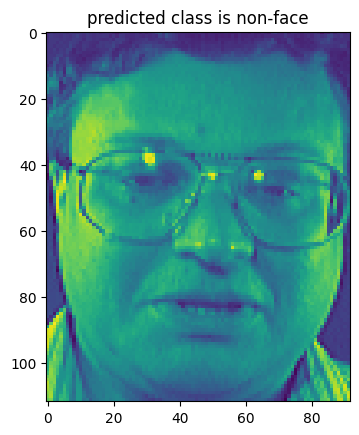

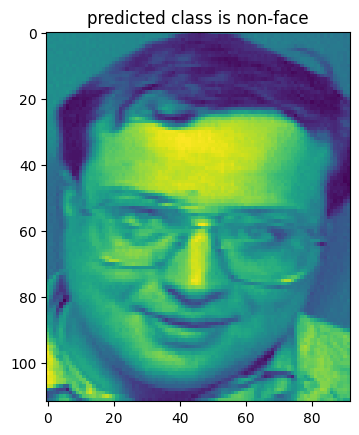

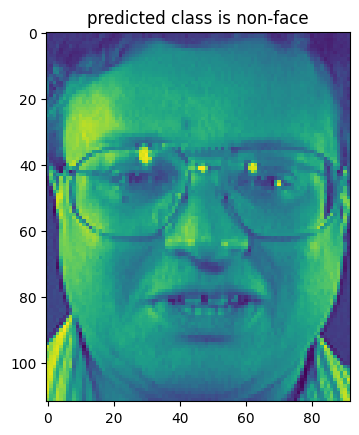

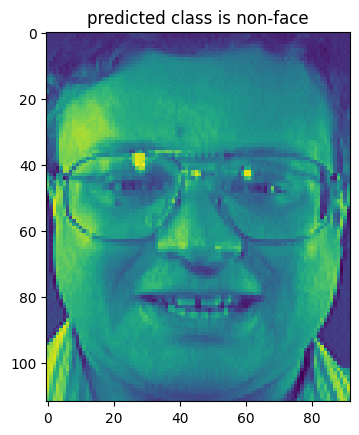

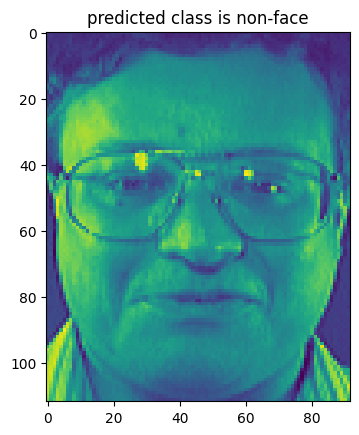

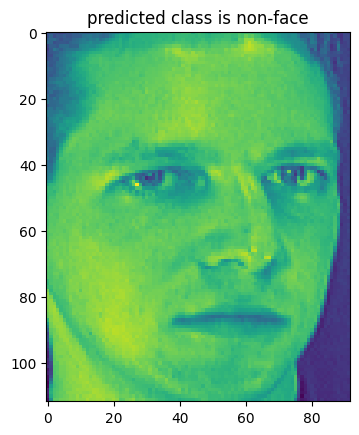

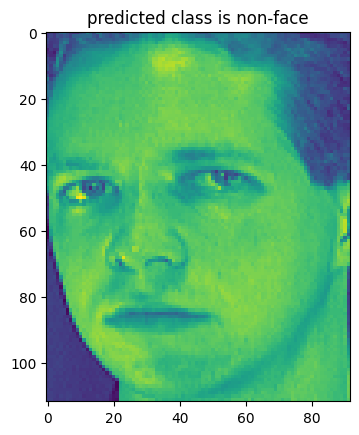

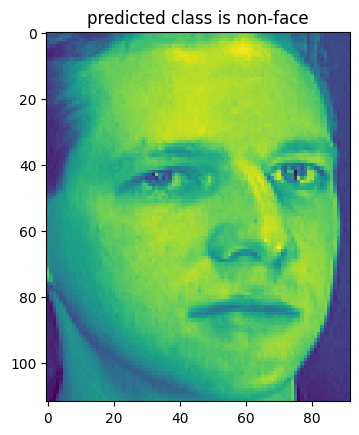

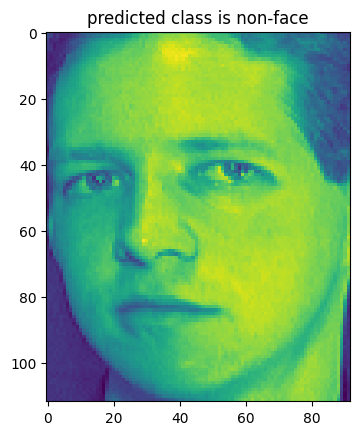

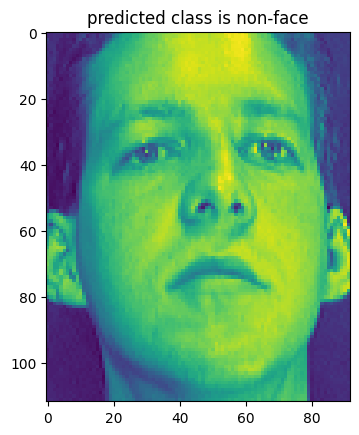

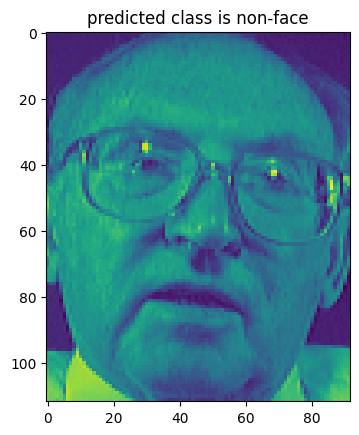

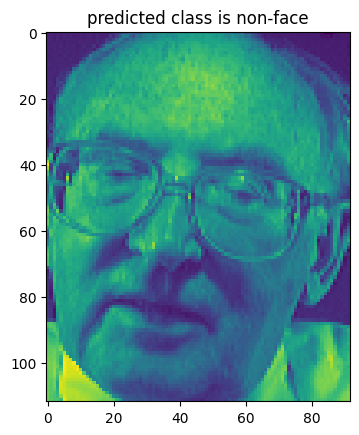

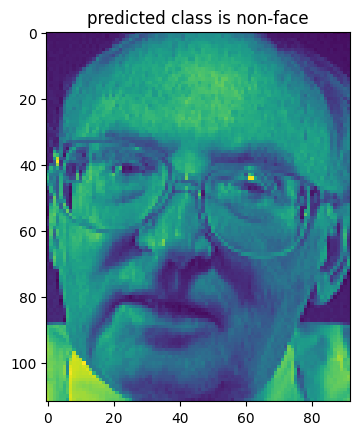

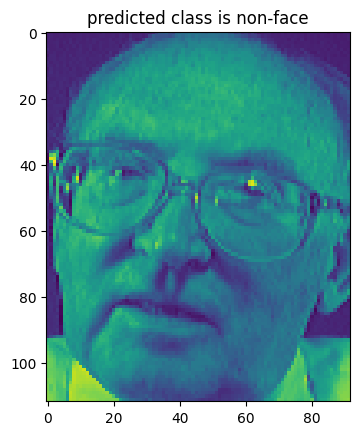

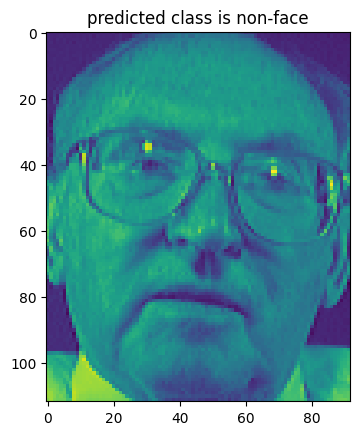

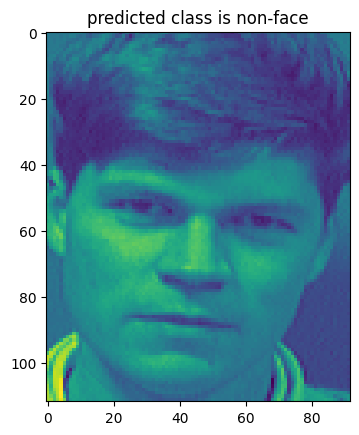

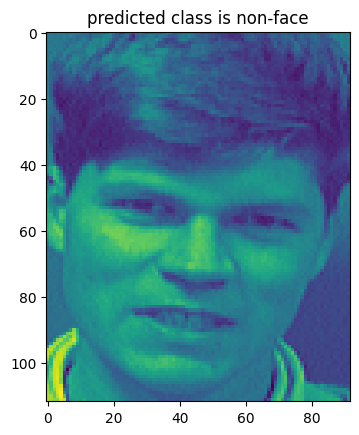

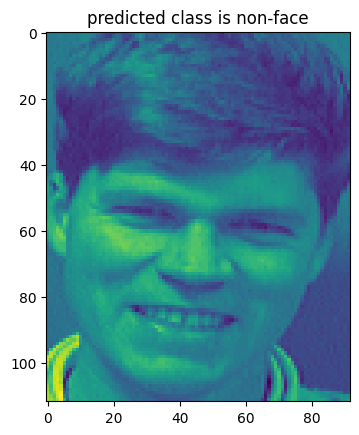

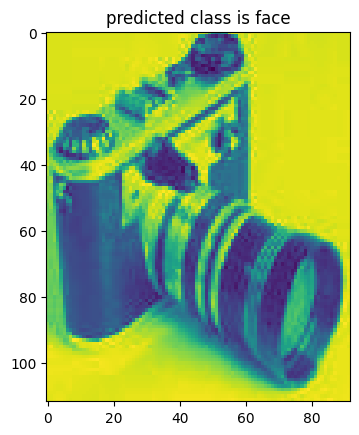

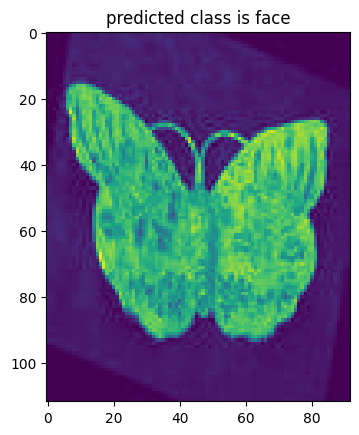

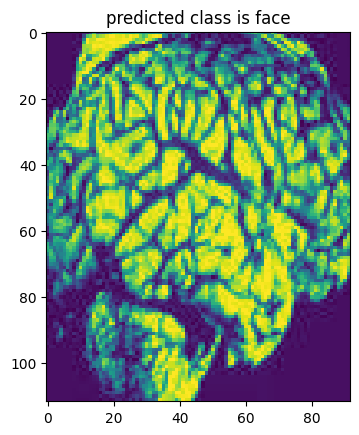

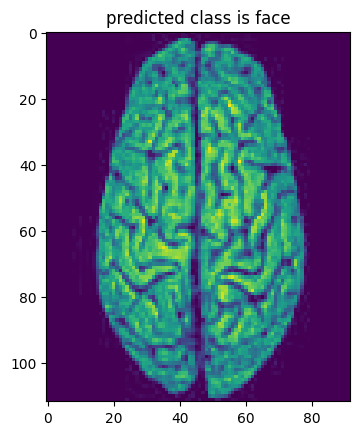

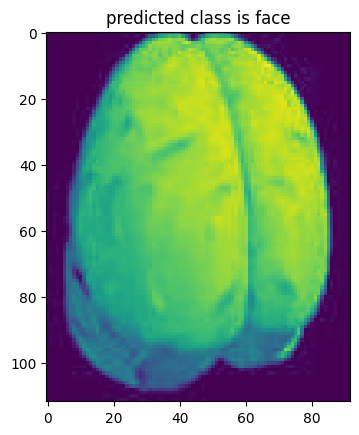

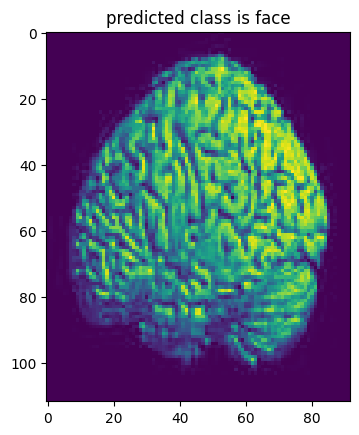

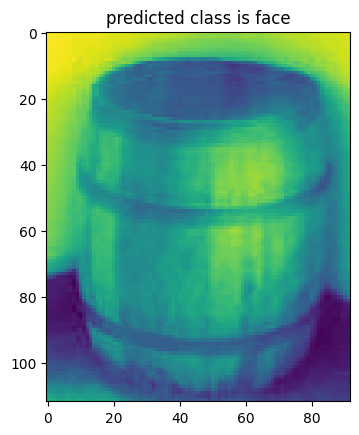

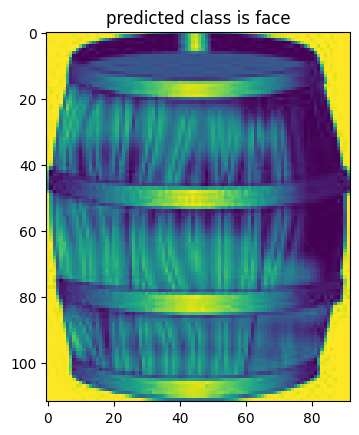

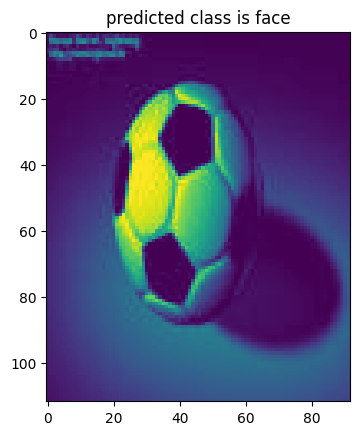

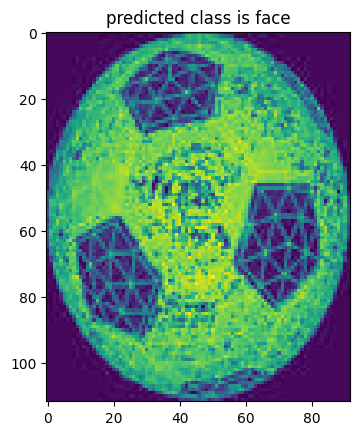

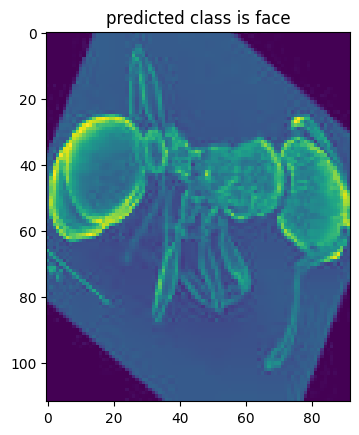

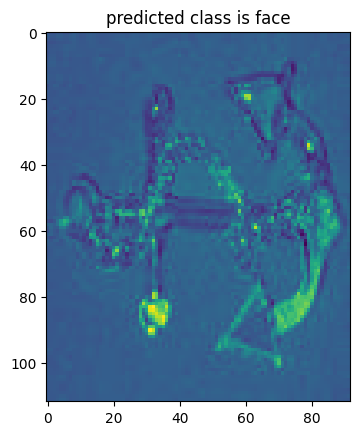

In [ ]:
for incorrect_example,class_prediction,true_class in ldaincorrect_examples[300]:
  incorrect_sample_img = test_set[incorrect_example]
  img = incorrect_sample_img.reshape(112,92)
  plt.imshow(img)
  predictied_class = "face" if class_prediction==1 else "non-face"
  plt.title(f"predicted class is {predictied_class}")
  plt.show()

In [ ]:
values = lda_collected_data.values()
values
lis = []
for val in values:
  lis.append(val)
lis

[50.0, 44.0, 79.0, 82.0, 82.0, 84.5]

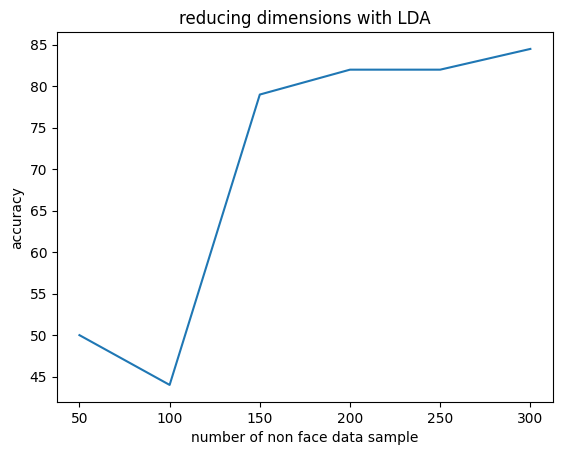

In [ ]:
plt.plot(range(50,301,50),lis)
plt.xlabel("number of non face data sample")
plt.ylabel("accuracy")
plt.title("reducing dimensions with LDA")
plt.show()